## Example Usage - Local Files

### Data-Loading

In [2]:
import dask
import numpy as np
import xarray as xr
import rioxarray as rxr
import re
import os
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import geojson
from shapely.geometry import shape
import json

In [10]:
# Path to the folder containing the COGs
data_dir = "/Volumes/RAID/felix_oemc/results_100m"

# Variables and bands of interest
variables = ["fapar", "lai", "fcover"]
bands = ["mean", "std", "count"]
years = range(2019, 2025)

dtype_mapping = {
    "mean": "int16",
    "std": "int16",
    "count": "int8"
}

min_max_scale = {
    "lai": {"min": 0, "max": 5.0, "scaling": 1000},
    "fapar": {"min": 0, "max": 1.0, "scaling": 10000},
    "fcover": {"min": 0, "max": 1.0, "scaling": 10000},
    "lai_std": {"min": 0, "max": 2.0, "scaling": 1000},
    "fapar_std": {"min": 0, "max": 0.3, "scaling": 10000},
    "fcover_std": {"min": 0, "max": 0.3, "scaling": 10000},
}

pattern = r"^(?P<var>fcover|fapar|lai)_rtm\.mlp_(?P<band>mean|std|count)_100m_s_(?P<start>\d{8})_(?P<end>\d{8})_go_epsg\.4326_v\d{2}\.tif$"


In [11]:
dataarray = defaultdict(lambda: defaultdict(list))

for file in os.listdir(data_dir):
    match = re.match(pattern, file)
    if match:
        var = match.group("var")
        band = match.group("band")
        start_date = match.group("start")  # Format: YYYYMMDD
        end_date = match.group("end")

        # Convert to datetime object
        time = datetime.strptime(start_date, "%Y%m%d")

        if int(time.year) in years:
            file_path = os.path.join(data_dir, file)
            da = rxr.open_rasterio(file_path, mask_and_scale=True, chunks = "auto").squeeze()
            da = da.assign_coords(time=time)

            dataarray.setdefault(var, {}).setdefault(band, []).append(da)
        else:
            warnings.warn(f"File {file} is not in the expected years range")

# concatenate all dataarrays for a given variable and band: concat time dimension
for var, bands in dataarray.items():
    for band, das in bands.items():
        dataarray[var][band] = xr.concat(das, dim="time")

# create a single dataset: 
ds = xr.Dataset()

for var, bands in dataarray.items():
    for band, da in bands.items():
        ds[f"{var}_{band}"] = da

In [12]:
print(ds.data_vars.keys())
ds['lai_mean']

KeysView(Data variables:
    fapar_count   (time, y, x) float32 dask.array<chunksize=(1, 11264, 11264), meta=np.ndarray>
    fapar_mean    (time, y, x) float32 dask.array<chunksize=(1, 8192, 8192), meta=np.ndarray>
    fapar_std     (time, y, x) float32 dask.array<chunksize=(1, 8192, 8192), meta=np.ndarray>
    fcover_count  (time, y, x) float32 dask.array<chunksize=(1, 11264, 11264), meta=np.ndarray>
    fcover_mean   (time, y, x) float32 dask.array<chunksize=(1, 8192, 8192), meta=np.ndarray>
    fcover_std    (time, y, x) float32 dask.array<chunksize=(1, 8192, 8192), meta=np.ndarray>
    lai_count     (time, y, x) float32 dask.array<chunksize=(1, 11264, 11264), meta=np.ndarray>
    lai_mean      (time, y, x) float32 dask.array<chunksize=(1, 8192, 8192), meta=np.ndarray>
    lai_std       (time, y, x) float32 dask.array<chunksize=(1, 8192, 8192), meta=np.ndarray>)


<xarray.DataArray 'lai_mean' (time: 6, y: 161414, x: 400752)>
dask.array<concatenate, shape=(6, 161414, 400752), dtype=float32, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 85.0 85.0 85.0 85.0 ... -60.0 -60.0 -60.0 -60.0
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2019-01-01 2020-01-01 ... 2024-01-01
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

### Visualize Raster

In [13]:
colors = {
        'lai': ["#fffdcd","#e1cd73","#aaac20","#5f920c","#187328","#144b2a","#172313",],
        'fcover': ["#f7fcf5", "#c7e9c0", "#74c476", "#238b45", "#00441b"],
        'fapar': ["#ffffdd", "#e6ad12", "#c53859", "#3a26a1", "#000000"],
        'std': ["#440154","#433982","#30678D","#218F8B","#36B677","#8ED542","#FDE725",]
    }

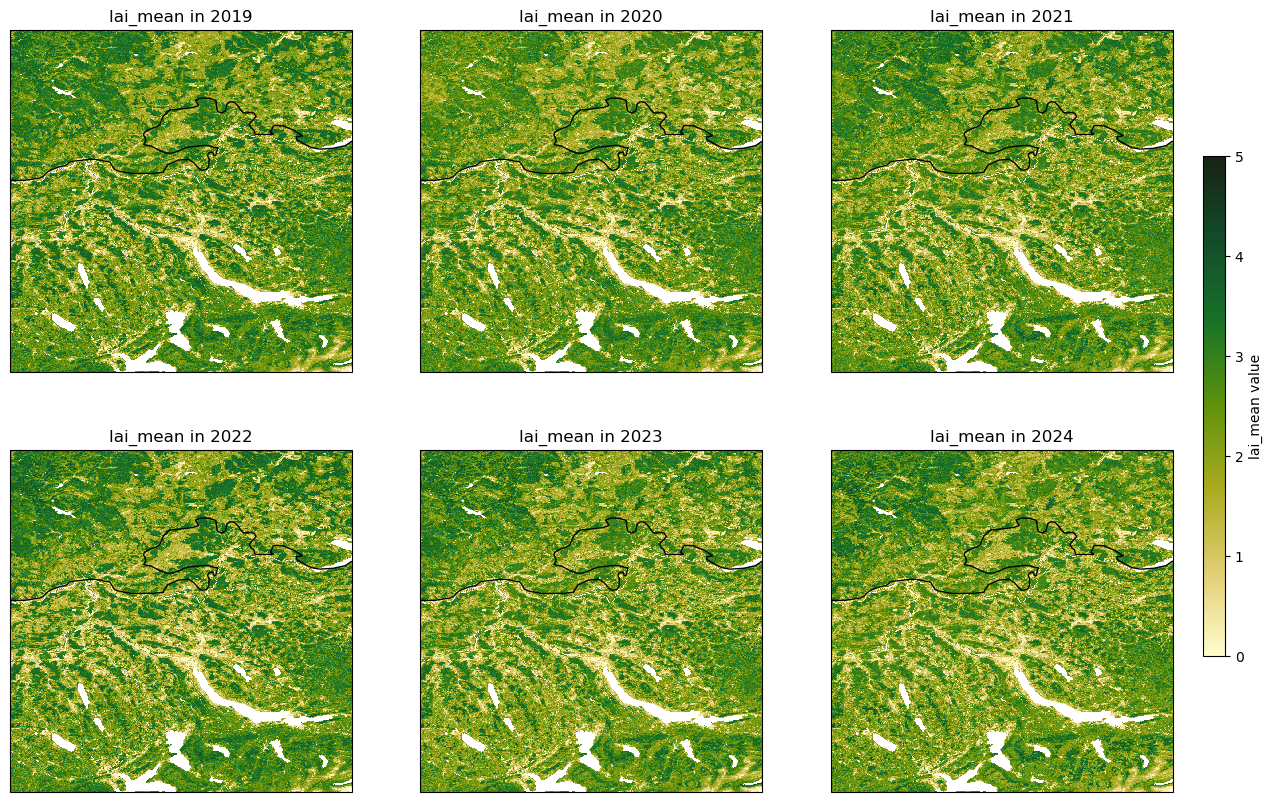

In [14]:
var_to_plot = "lai_mean"

bbox = {
    "min_lon": 8.0,
    "max_lon": 9.0,
    "min_lat": 47,
    "max_lat": 48 
}

ds_subset = ds.sel(
    x=slice(bbox["min_lon"], bbox["max_lon"]),
    y=slice(bbox["max_lat"], bbox["min_lat"])
)

current_color = colors[var_to_plot.split("_")[0]]

years = sorted(set(pd.to_datetime(ds_subset.time.values).year))

fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin, vmax = min_max_scale[var_to_plot.split("_")[0]]["min"], min_max_scale[var_to_plot.split("_")[0]]["max"]

for i, year in enumerate(years[:6]):  # Ensure we only take up to 6 years
    da_to_plot = ds_subset[var_to_plot].sel(time=str(year)).squeeze() # squeeze to remove time dimension
    im = da_to_plot.plot.imshow(ax=axes[i], cmap=mcolors.LinearSegmentedColormap.from_list("custom_cmap", current_color, N=256, ), add_colorbar=False, vmin=vmin, vmax=vmax)

    axes[i].add_feature(cfeature.BORDERS, linestyle="-")
    axes[i].add_feature(cfeature.COASTLINE)
    axes[i].add_feature(cfeature.LAND, edgecolor="black", facecolor="none")
    axes[i].set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]], crs=ccrs.PlateCarree())
    axes[i].set_title(f"{var_to_plot} in {year}")

cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(f"{var_to_plot} value")

plt.show()


### Extract time-series

In [18]:
var = "lai"
var_mean = f"{var}_mean"
var_std = f"{var}_std"
year_first = 2019
year_last = 2024

bbox = {
    "min_lon": -90.5,
    "max_lon": -90,
    "min_lat": 18.5,
    "max_lat": 19 
}

geometry_geojson = '''{
    "type": "Polygon",
    "coordinates": [[
        [-90.14449623835071, 18.67495312528892],
        [-90.14338043940052, 18.67426197415629],
        [-90.14342335474475, 18.673530164003317],
        [-90.14303711664661, 18.67226981689038],
        [-90.14308003199085, 18.670724862486605],
        [-90.14209297907337, 18.6699523800057],
        [-90.14226464045032, 18.66824477466564],
        [-90.14174965631946, 18.66726899246539],
        [-90.14076260340198, 18.672676381498913],
        [-90.13655689966663, 18.670724862486605],
        [-90.13471153986438, 18.671537998138163],
        [-90.12921837580188, 18.671700624800515],
        [-90.12389687311634, 18.67092814676507],
        [-90.12368229639515, 18.673692788754767],
        [-90.12153652918323, 18.67849014873624],
        [-90.1172449947594, 18.680156996266007],
        [-90.11514214289173, 18.682555601744617],
        [-90.11806038629993, 18.6841411019806],
        [-90.11694458734974, 18.686458344866995],
        [-90.11999157679065, 18.688369030070728],
        [-90.12300763631379, 18.68418175563771],
        [-90.12442384267365, 18.68296214168103],
        [-90.13107572103058, 18.688938166178186],
        [-90.13446603322541, 18.685807893923194],
        [-90.139615874534, 18.685685934093193],
        [-90.13918672109162, 18.690198389324944],
        [-90.14322076345002, 18.690645563026294]]]}'''

# cropping_geometry = [geojson.loads(geometry_geojson)]
polygon = shape(json.loads(geometry_geojson))

buffered_bbox = polygon.buffer(0.02).bounds
ds_subset = ds.sel(
    x=slice(buffered_bbox[0], buffered_bbox[2]),
    y=slice(buffered_bbox[3], buffered_bbox[1])
)

# Extract time series for a polygon
clipped_ds_mean = ds_subset[var_mean].rio.clip([polygon], crs=4326)
clipped_ds_std = ds_subset[var_std].rio.clip([polygon], crs=4326) 
site_ts_mean = clipped_ds_mean.mean(dim=["x", "y"]).to_dataframe()[var_mean]
site_ts_std = clipped_ds_std.mean(dim=["x", "y"]).to_dataframe()[var_std]

site_ts = pd.concat([site_ts_mean, site_ts_std], axis=1)

# create new column "mean_upper", "mean_lower" 
site_ts["mean_upper"] = site_ts[var_mean] + site_ts[var_std]
site_ts["mean_lower"] = site_ts[var_mean] - site_ts[var_std]
print(site_ts)

# Define colormaps
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", current_color, N=256)
change_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["purple", "white", "green"], N=256)

# Extract 2019 and 2024 data
da_2019 = ds_subset[var_mean].sel(time=str(year_first)).squeeze()
da_2024 = ds_subset[var_mean].sel(time=str(year_last)).squeeze()
da_change = da_2024 - da_2019  # Compute difference

min_max_change = {
    'lai': [-2, 2],
    'fcover': [-0.5, 0.5],
    'fapar': [-0.5, 0.5],
}

change_vmin, change_vmax = min_max_change[var_to_plot.split("_")[0]]


            lai_mean   lai_std  mean_upper  mean_lower
time                                                  
2019-01-01  1.435249  0.583885    2.019135    0.851364
2020-01-01  1.470279  0.589208    2.059487    0.881072
2021-01-01  2.001806  0.567507    2.569312    1.434299
2022-01-01  1.920195  0.554268    2.474463    1.365927
2023-01-01  1.959069  0.660502    2.619572    1.298567
2024-01-01  1.926186  0.907463    2.833650    1.018723


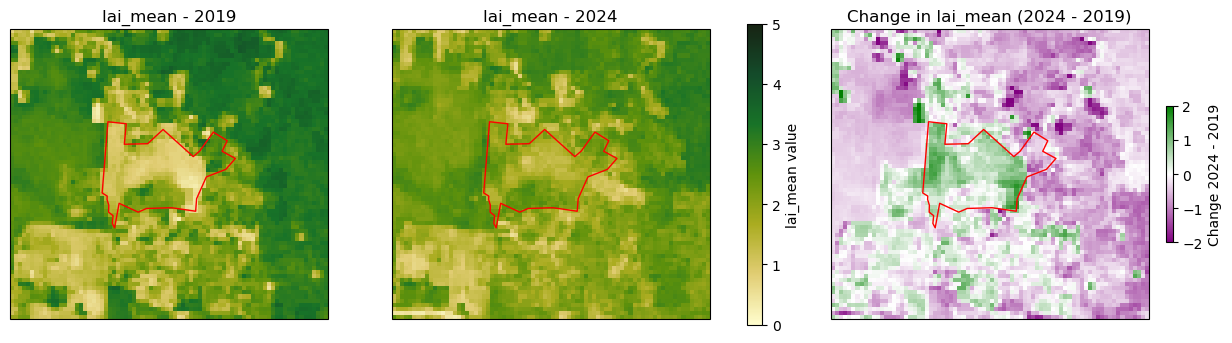

In [19]:
# Create 3-panel figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

# Plot 2019 trait map
im1 = da_2019.plot.imshow(ax=axes[0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
# add polygon to the raster
axes[0].add_geometries([polygon], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red')
axes[0].set_title(f"{var_to_plot} - {year_first}")

# Plot 2024 trait map
im2 = da_2024.plot.imshow(ax=axes[1], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
axes[1].add_geometries([polygon], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red')
axes[1].set_title(f"{var_to_plot} - {year_last}")

# Plot change map (2024 - 2019)
im3 = da_change.plot.imshow(ax=axes[2], cmap=change_cmap, add_colorbar=False, vmin=change_vmin, vmax=change_vmax)
axes[2].add_geometries([polygon], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red')
axes[2].set_title(f"Change in {var_to_plot} ({year_last} - {year_first})")

# Colorbars
fig.colorbar(im1, ax=axes[:2], orientation="vertical", fraction=0.02, pad=0.05, label=f"{var_to_plot} value")
fig.colorbar(im3, ax=axes[2], orientation="vertical", fraction=0.02, pad=0.05, label=f"Change {year_last} - {year_first}")
plt.show()


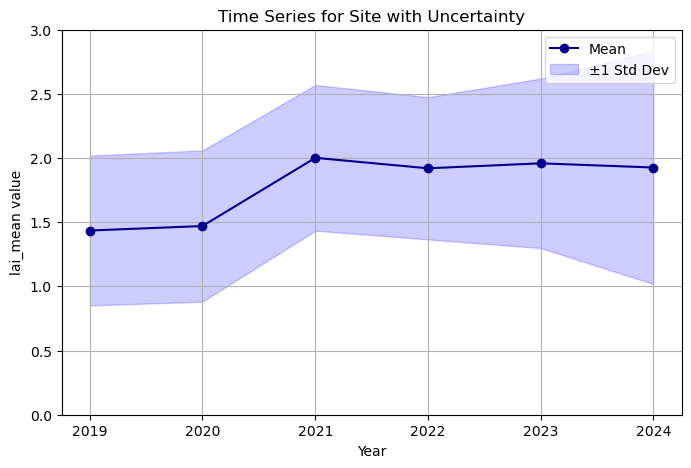

In [22]:
### PLOT 2: TIME SERIES WITH UNCERTAINTY ###
fig2, ax2 = plt.subplots(figsize=(8, 5))

# Ensure time index is datetime
site_ts.index = pd.to_datetime(site_ts.index)

# Plot time series with shaded uncertainty
ax2.plot(site_ts.index, site_ts_mean, marker="o", linestyle="-", color="darkblue", label="Mean")
ax2.fill_between(site_ts.index, site_ts_mean - site_ts_std, site_ts_mean + site_ts_std, 
                 color="blue", alpha=0.2, label="±1 Std Dev")

ax2.set_xlabel("Year")
ax2.set_ylabel(f"{var_to_plot} value")
ax2.set_ylim(0, 3)
ax2.set_title(f"Time Series for Site with Uncertainty")
ax2.legend()
ax2.grid(True)

plt.show()
